# Dimansionality Reduction

## T-SNE

In [1]:
import pandas as pd
from sklearn.manifold import TSNE
from matplotlib import pyplot as plt

In [2]:
female = pd.read_csv('http://tools.openlab.psu.edu/publicData/ANSUR_II_FEMALE_Public.csv', encoding='latin-1')

In [3]:
male = pd.read_csv('http://tools.openlab.psu.edu/publicData/ANSUR_II_MALE_Public.csv', encoding='latin-1')

In [4]:
print(male.shape[0]); print(female.shape[0])

4082
1986


In [19]:
ansur = pd.concat([male, female])

In [22]:
ansur.to_csv('../dataset/ansur.csv', index=False)

In [34]:
numeric = ansur.select_dtypes(exclude='object').drop(['subjectid', 'SubjectId'], axis=1)

In [44]:
tsne = TSNE(learning_rate=50)
tsne_features = tsne.fit_transform(numeric)

In [45]:
tsne_features.shape

(6068, 2)

In [72]:
ansur.describe(exclude='number')

,Gender,Date,Installation,Component,Branch,PrimaryMOS,SubjectsBirthLocation,Ethnicity,WritingPreference
count,6068,6068,6068,6068,6068,6068,6068,1421,6068
unique,2,253,12,3,3,285,152,209,3
top,Male,27-Feb-12,Camp Shelby,Regular Army,Combat Service Support,11B,California,Mexican,Right hand
freq,4082,45,1160,3140,3174,671,446,357,5350


In [58]:
hue = ['blue' if x=='Male' else 'red' for x in ansur['Gender']]

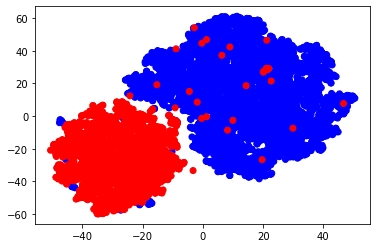

In [60]:
plt.scatter(x = tsne_features[:,0], y = tsne_features[:,1], c=hue)

In [77]:
hue = ['blue' if x=='Right hand' else ('green' if x=='Left hand' else 'red') for x in ansur['WritingPreference']]

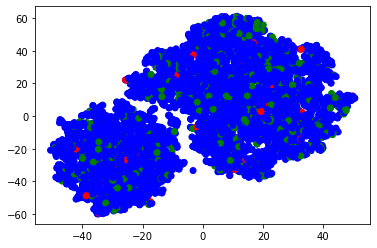

In [81]:
plt.scatter(x = tsne_features[:,0], y = tsne_features[:,1], c=hue)

# Features Selection  
- remove features with low varience `Alway normalized data to compare varince across features`  
- remove features with NA

In [43]:
import pandas as pd

ansur = (pd
.read_csv('../dataset/ansur.csv')
.select_dtypes('integer')
.drop(['DODRace','SubjectNumericRace'], axis=1) # remove categorical in number dtypes
)

<AxesSubplot:>

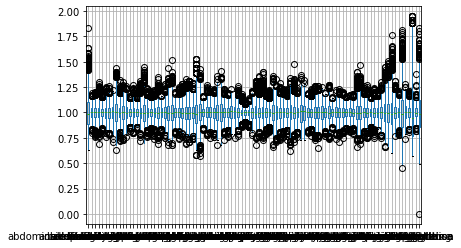

In [37]:
# normalized data, boxplot for varince
(ansur/ansur.mean()).boxplot()

<AxesSubplot:>

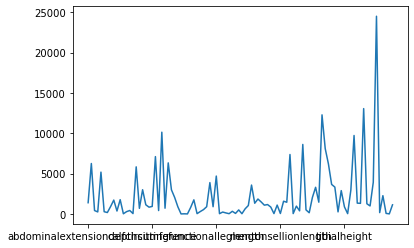

In [50]:
# Varience of raw data
(ansur.std()**2).plot()

<AxesSubplot:>

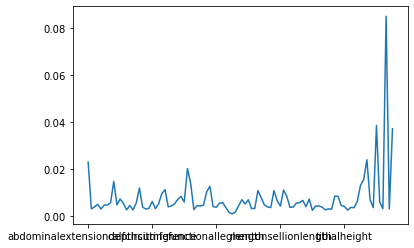

In [51]:
# varience of normalized data
((ansur/ansur.mean()).std()**2).plot()

### Remove low varience features

In [5]:
from sklearn.feature_selection import VarianceThreshold
sel = VarianceThreshold(threshold=0.02)
sel.fit(ansur/ansur.mean())
mask = sel.get_support()

In [6]:
ansur_reduce = ansur.loc[:, mask]

In [7]:
ansur_reduce.head()

,abdominalextensiondepthsitting,earprotrusion,waistdepth,weightkg,Age,Weightlbs
0,266,19,240,815,41,180
1,233,18,225,726,35,160
2,287,23,255,929,42,205
3,234,25,205,794,31,175
4,250,19,214,946,21,213


### Remove missing values

In [58]:
# calculate % missing value by features
(ansur.isna().sum()/ansur.shape[0]).nlargest(10)

abdominalextensiondepthsitting    0.0
acromialheight                    0.0
acromionradialelength             0.0
anklecircumference                0.0
axillaheight                      0.0
balloffootcircumference           0.0
balloffootlength                  0.0
biacromialbreadth                 0.0
bicepscircumferenceflexed         0.0
bicristalbreadth                  0.0
dtype: float64

In [62]:
mask = ansur.isna().sum()/ansur.shape[0] < 0.9

In [63]:
ansur_reduce = ansur.loc[:, mask]

In [64]:
ansur_reduce.shape

(6068, 96)

## Correlation Coefficient as Feature selection

In [15]:
from matplotlib import pyplot as plt
import numpy as np

In [8]:
corr = ansur_reduce.corr()

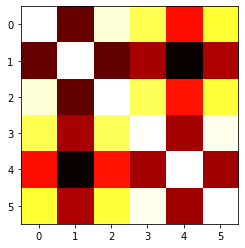

In [12]:
fig, ax = plt.subplots()
ax.imshow(corr, cmap='hot')

In [13]:
corr

,abdominalextensiondepthsitting,earprotrusion,waistdepth,weightkg,Age,Weightlbs
abdominalextensiondepthsitting,1.000000,0.132538,0.958932,0.825714,0.380614,0.793634
earprotrusion,0.132538,1.000000,0.124523,0.230755,-0.006626,0.243373
waistdepth,0.958932,0.124523,1.000000,0.832213,0.389865,0.801158
weightkg,0.825714,0.230755,0.832213,1.000000,0.228096,0.978361
Age,0.380614,-0.006626,0.389865,0.228096,1.000000,0.220190
Weightlbs,0.793634,0.243373,0.801158,0.978361,0.220190,1.000000


In [17]:
# Calculate the correlation matrix and take the absolute value
corr_matrix = ansur_reduce.corr().abs()

# Create a True/False mask and apply it
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
tri_df = corr_matrix.mask(mask)

# List column names of highly correlated features (r > 0.95)
to_drop = [c for c in tri_df.columns if any(tri_df[c] >  0.95)]

# Drop the features in the to_drop list
reduced_df = ansur_reduce.drop(to_drop, axis=1)

print("The reduced dataframe has {} columns.".format(reduced_df.shape[1]))

The reduced dataframe has 4 columns.



### Regression coefficient for features selection  
-  `**Must** standardized` all the features to be comparable

In [38]:
from sklearn.datasets import load_diabetes
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score

X, y = load_diabetes(return_X_y=True, as_frame=True)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

In [35]:
pipe = Pipeline(steps= [('scales', StandardScaler()), ('estimator', LogisticRegression())])

In [37]:
pipe.fit(X_train, y_train)

Pipeline(steps=[('scales', StandardScaler()),
                ('estimator', LogisticRegression())])

In [39]:
y_pre = pipe.predict(X_test)

In [40]:
accuracy_score(y_pre, y_test)

0.2932330827067669

In [41]:
print(dict(zip(X.columns, abs(pipe['estimator'].coef_[0]).round(2))))

{'age': 0.09, 'sex': 0.42, 'bmi': 0.04, 'bp': 0.21, 's1': 0.27, 's2': 0.24, 's3': 0.02, 's4': 0.3, 's5': 0.04, 's6': 0.33}


In [42]:
from sklearn.feature_selection import RFE

In [44]:
rfe = RFE(estimator=LogisticRegression(), n_features_to_select=3, verbose=1)

# Fits the eliminator to the data
rfe.fit(X_train, y_train)

# Print the features and their ranking (high = dropped early on)
print(dict(zip(X.columns, rfe.ranking_)))

# Print the features that are not eliminated
print(X.columns[rfe.support_])

# Calculates the test set accuracy
acc = accuracy_score(y_test, rfe.predict(X_test))
print("{0:.1%} accuracy on test set.".format(acc)) 

Fitting estimator with 10 features.
Fitting estimator with 9 features.
Fitting estimator with 8 features.
Fitting estimator with 7 features.
Fitting estimator with 6 features.
Fitting estimator with 5 features.
Fitting estimator with 4 features.
{'age': 3, 'sex': 6, 'bmi': 1, 'bp': 1, 's1': 7, 's2': 8, 's3': 2, 's4': 5, 's5': 1, 's6': 4}
Index(['bmi', 'bp', 's5'], dtype='object')
1.5% accuracy on test set.


## Features importance with RF

In [37]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import load_diabetes
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.feature_selection import RFE

In [28]:
X, y = load_diabetes(return_X_y=True, as_frame=True)
y_flag = ['positive' if i > 120 else 'negative' for i in y]
X_train, X_test, y_train, y_test = train_test_split(X, y_flag, test_size=0.25, random_state=0, stratify=y_flag)

In [29]:
rf = RandomForestClassifier(random_state=0)
rf.fit(X_train, y_train)

RandomForestClassifier(random_state=0)

In [31]:
acc = accuracy_score(rf.predict(X_test), y_test)

In [33]:
print(dict(zip(X.columns, rf.feature_importances_.round(2))))

{'age': 0.07, 'sex': 0.01, 'bmi': 0.19, 'bp': 0.09, 's1': 0.07, 's2': 0.07, 's3': 0.16, 's4': 0.08, 's5': 0.19, 's6': 0.07}


In [34]:
mask = rf.feature_importances_ > 0.15

In [35]:
X_reduce = X.loc[:, mask]

In [36]:
X_reduce.columns

Index(['bmi', 's3', 's5'], dtype='object')

In [39]:
rfe = RFE(estimator=rf, n_features_to_select=2, verbose=True)
rfe.fit(X_train, y_train)

Fitting estimator with 10 features.
Fitting estimator with 9 features.
Fitting estimator with 8 features.
Fitting estimator with 7 features.
Fitting estimator with 6 features.
Fitting estimator with 5 features.
Fitting estimator with 4 features.
Fitting estimator with 3 features.


RFE(estimator=RandomForestClassifier(random_state=0), n_features_to_select=2,
    verbose=True)

In [41]:
mask = rfe.support_

In [42]:
print(X.loc[:, mask].columns)

Index(['bmi', 's5'], dtype='object')


## Features selection with Lasso

In [45]:
from sklearn.linear_model import Lasso
from sklearn.preprocessing import StandardScaler

In [58]:
ansur['bmi'] = ansur['weightkg']/(ansur['Heightin']/0.0254)**2
ansur_reduce = ansur.drop(['weightkg', 'Heightin'], axis=1)
X, y = ansur_reduce.drop(['bmi'], axis=1), ansur_reduce['bmi']

In [60]:
scaler = StandardScaler()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)
X_train_std = scaler.fit_transform(X_train)

le = Lasso()
le.fit(X_train_std, y_train)

Lasso()

In [63]:
le.coef_

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0.])

## LassoCV : automatically tune model

In [69]:
from sklearn.linear_model import LassoCV

lcv = LassoCV()

lcv.fit(X_test, y_test)

LassoCV()

In [70]:
print('Optimal alpha = {0:.3f}'.format(lcv.alpha_))

Optimal alpha = 0.000


In [71]:
from sklearn.ensemble import GradientBoostingRegressor

# Feature Extraction

In [1]:
import pandas as pd

ansur = (pd
.read_csv('../dataset/ansur.csv')
.select_dtypes('integer')
.drop(['DODRace','SubjectNumericRace'], axis=1) # remove categorical in number dtypes
)

In [17]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline

scalar = StandardScaler()
pca = PCA()

In [8]:
ansur_std = scalar.fit_transform(ansur)
ansur_pc = pca.fit_transform(ansur_std)

In [10]:
pc_df = pd.DataFrame(ansur_pc)

In [14]:
pca.explained_variance_ratio_[:10]

array([0.55832117, 0.12466027, 0.0497659 , 0.03101601, 0.022498  ,
       0.01587832, 0.01384041, 0.01203297, 0.01108501, 0.00975636])

In [15]:
pca.explained_variance_ratio_.cumsum()[:10]

array([0.55832117, 0.68298144, 0.73274734, 0.76376335, 0.78626135,
       0.80213967, 0.81598008, 0.82801305, 0.83909807, 0.84885443])

In [22]:
pipe = Pipeline([
    ('scalar', StandardScaler()),
    ('pca', PCA(n_components=2))
])

In [24]:
pipe.fit(ansur)

Pipeline(steps=[('scalar', StandardScaler()), ('pca', PCA(n_components=2))])

In [33]:
vectors = pipe.steps[1][1].components_.round(2)

In [34]:
print('PC 1 effects = ' + str(dict(zip(ansur.columns, vectors[0]))))
print('PC 2 effects = ' + str(dict(zip(ansur.columns, vectors[1]))))

PC 1 effects = {'abdominalextensiondepthsitting': -0.08, 'acromialheight': -0.13, 'acromionradialelength': -0.11, 'anklecircumference': -0.09, 'axillaheight': -0.12, 'balloffootcircumference': -0.11, 'balloffootlength': -0.12, 'biacromialbreadth': -0.12, 'bicepscircumferenceflexed': -0.1, 'bicristalbreadth': -0.06, 'bideltoidbreadth': -0.12, 'bimalleolarbreadth': -0.11, 'bitragionchinarc': -0.1, 'bitragionsubmandibulararc': -0.1, 'bizygomaticbreadth': -0.09, 'buttockcircumference': -0.07, 'buttockdepth': -0.08, 'buttockheight': -0.11, 'buttockkneelength': -0.11, 'buttockpopliteallength': -0.1, 'calfcircumference': -0.09, 'cervicaleheight': -0.13, 'chestbreadth': -0.1, 'chestcircumference': -0.1, 'chestdepth': -0.07, 'chestheight': -0.12, 'crotchheight': -0.11, 'crotchlengthomphalion': -0.06, 'crotchlengthposterioromphalion': -0.06, 'earbreadth': -0.06, 'earlength': -0.07, 'earprotrusion': -0.04, 'elbowrestheight': -0.04, 'eyeheightsitting': -0.1, 'footbreadthhorizontal': -0.11, 'footle

In [48]:
pc = pca.fit_transform(ansur_std)

In [52]:
ansur['PC0'] = pc[:,0]
ansur['PC1'] = pc[:,1]

<AxesSubplot:xlabel='PC0', ylabel='PC1'>

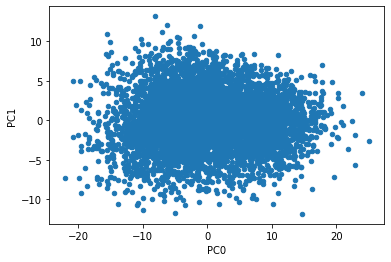

In [54]:
c_code = [c for c in ansur['']]
ansur[['PC0', 'PC1']].plot(kind='scatter', x = 'PC0', y='PC1')

In [57]:
# Let PCA select 90% of the variance
pipe = Pipeline([('scaler', StandardScaler()),
        		 ('reducer', PCA(n_components=0.8))])

# Fit the pipe to the data
pipe.fit(ansur)

print('{} components selected'.format(len(pipe.steps[1][1].components_)))

6 components selected


In [60]:
from matplotlib import pyplot as plt

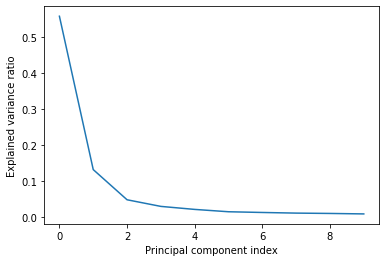

In [61]:
# Pipeline a scaler and pca selecting 10 components
pipe = Pipeline([('scaler', StandardScaler()),
        		 ('reducer', PCA(n_components=10))])

# Fit the pipe to the data
pipe.fit(ansur)

# Plot the explained variance ratio
plt.plot(pipe.steps[1][1].explained_variance_ratio_)

plt.xlabel('Principal component index')
plt.ylabel('Explained variance ratio')
plt.show()

## PCA as image reduction